## Tugas
- Lakukan klasifikasi pada data MNIST dengan menggunakan model ANN
- Anda diperbolehkan melakukan eksplorasi terhadap,
    - Metode pra pengolahan
    - Pemilihan fitur
    - Arsitektur ANN
    - Fungsi Aktiviasi
- ANN diimplementasikan dengan menggunakan tensorflow.
- DIKERJAKAN SECARA BERKELOMPOK
- JELASKAN HASIL YANG ANDA DAPATKAN,
    - AKURASI
    - CONFUSION MATRIX
    - KONFIGURASI MODEL --> MULAI DARI PRA PENGOLAHAN SAMPAI ARSITEKTUR ANN

#### Tahap 1: Unduh dataset MNIST dan impor library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_openml

In [6]:
mnist = datasets.fetch_openml("mnist_784", parser='auto')

#### Tahap 2: Eksplorasi Data

In [21]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Jumlah data setiap label:
Label 0: 6903 data
Label 1: 7877 data
Label 2: 6990 data
Label 3: 7141 data
Label 4: 6824 data
Label 5: 6313 data
Label 6: 6876 data
Label 7: 7293 data
Label 8: 6825 data
Label 9: 6958 data


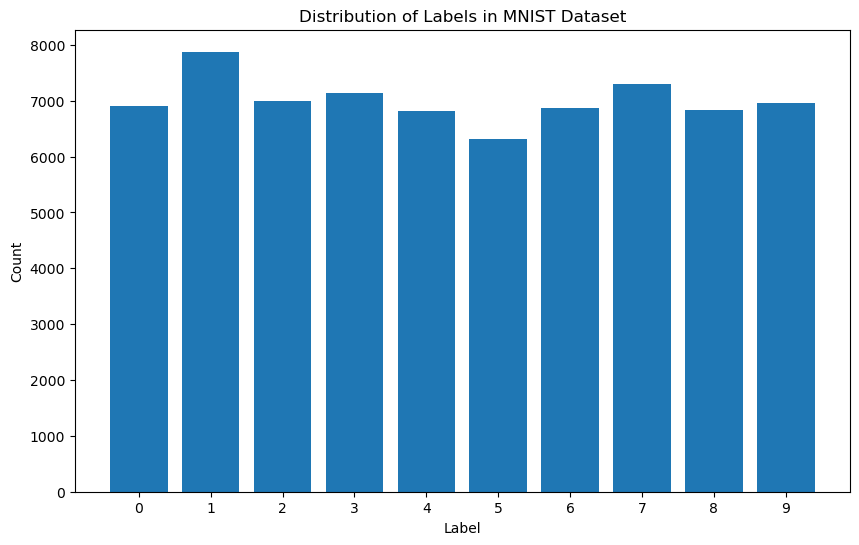

In [7]:
# 1. Eksplorasi Dataset
labels, counts = np.unique(mnist.target, return_counts=True)
print("Jumlah data setiap label:")
for label, count in zip(labels, counts):    
    print(f"Label {label}: {count} data")

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, tick_label=labels)

# Adding labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in MNIST Dataset')

# Show the plot
plt.show()

In [16]:
import pandas as pd

# Data kelas Anda dalam bentuk dictionary
data = {
    'Label': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Jumlah Data': [6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Menghitung total jumlah data
total_data = df['Jumlah Data'].sum()

# Menambahkan kolom "Persentase" yang berisi persentase distribusi
df['Persentase'] = (df['Jumlah Data'] / total_data) * 100

# Menampilkan DataFrame
print(df)

# Mengevaluasi keseimbangan data
threshold = 5  # Threshold persentase minimum (jika ada yang 5% terlalu signifikan perbedaanya)
imbalanced = (df['Persentase'] < threshold).any()

if imbalanced:
    print("\nData tidak seimbang.")
else:
    print("\nData seimbang.")

   Label  Jumlah Data  Persentase
0      0         6903    9.861429
1      1         7877   11.252857
2      2         6990    9.985714
3      3         7141   10.201429
4      4         6824    9.748571
5      5         6313    9.018571
6      6         6876    9.822857
7      7         7293   10.418571
8      8         6825    9.750000
9      9         6958    9.940000

Data seimbang.


#### Tahap 3: Metode Pra-pengolahan

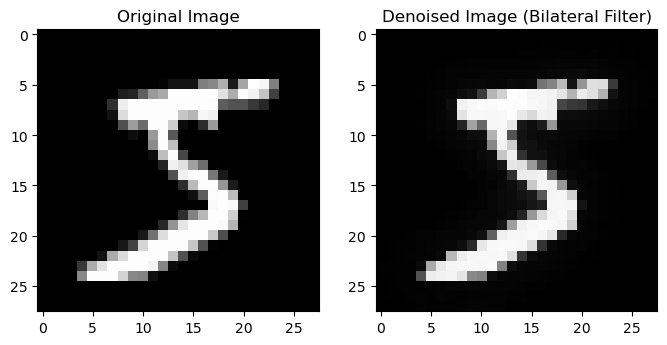

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Muat dataset MNIST
mnist_data = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

# Ambil data gambar dan label
mnist_images = mnist_data.data
mnist_labels = mnist_data.target.astype(int)

# Normalisasi data
mnist_images = mnist_images / 255.0

# Fungsi untuk pengurangan noise (Bilateral Filter)
def denoise_image(image):
    image = (image * 255).astype(np.uint8)  # Konversi ke format 8-bit unsigned
    image = image.reshape(28, 28)
    denoised_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return denoised_image.flatten()

# Terapkan pengurangan noise pada semua gambar (opsional)
mnist_images_denoised = np.array([denoise_image(image) for image in mnist_images])

# Contoh tampilan gambar asli dan gambar setelah pengurangan noise
sample_image = mnist_images[0].reshape(28, 28)
sample_denoised_image = mnist_images_denoised[0].reshape(28, 28)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Denoised Image (Bilateral Filter)")
plt.imshow(sample_denoised_image, cmap='gray')

plt.show()


#### Tahap 4: Ambil data dan label

In [60]:
# Mengambil data gambar dan label
X = mnist_images_denoised.astype('float32')
y = mnist_labels

X.shape

(70000, 784)

In [62]:
print(X[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Karena sudah dinormalisasi ketika preprocessing, maka tidak perlu scalling lagi.

#### Tahap 5: Ekstraksi Fitur dengan PCA dan split dataset serta flattening data

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA as RandomizedPCA

n_components = 200
pca = RandomizedPCA(n_components =n_components, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

In [68]:
# Flattening data setelah PCA
X_flattened = X_pca.reshape(X_pca.shape[0], -1)

In [69]:
# Memisahkan data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#### Tahap 6: Membuat model ANN dan training model 

In [96]:
import tensorflow as tf
from tensorflow import keras

# Membuat model ANN
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n_components,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Menampilkan ringkasan model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 200)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 128)               │     25,728 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 84)                │     10,836 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 10)                │        850 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 37,414 (146.15 KB)

 Trainable params: 37,414 (146.15 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Langkah 1 - Compile Model (Menyatukan Arsitektur) ANN
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Langkah 2 - Fitting Model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9973 - loss: 0.0077 - val_accuracy: 0.9504 - val_loss: 0.3241
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9958 - loss: 0.0139 - val_accuracy: 0.9480 - val_loss: 0.3266
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.0074 - val_accuracy: 0.9537 - val_loss: 0.3260
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9979 - loss: 0.0063 - val_accuracy: 0.9536 - val_loss: 0.3144
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9528 - val_loss: 0.3232
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.9501 - val_loss: 0.3665
Epoch 7/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9511 - val_loss: 0.3554
Epoch 8/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9975 - loss: 0.0082 - val_accuracy: 0.

#### Tahap 7: Evaluasi

In [99]:
test_lost, test_acc = model.evaluate(X_test, y_test)
print(f"Kerugian pada data pelatihan: {test_lost: .2f}")
print(f"Akurasi pada data pelatihan: {test_acc: .2f}")

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9570 - loss: 0.3842
Kerugian pada data pelatihan:  0.38
Akurasi pada data pelatihan:  0.96


In [95]:
train_lost, train_acc = model.evaluate(X_train, y_train)
print(f"Kerugian pada data pengujian: {train_lost: .2f}")
print(f"Akurasi pada data pengujian: {train_acc: .2f}")

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9965 - loss: 0.0143
Kerugian pada data pengujian:  0.07
Akurasi pada data pengujian:  0.99


### Confusion Matrix

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


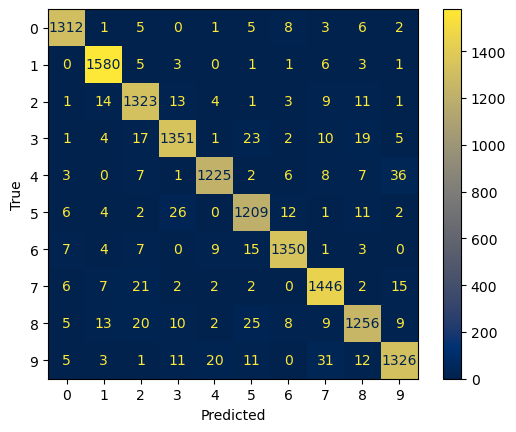

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data confusion matrix
predict = model.predict(X_test)
prediction_labels = np.argmax(predict, axis=1)
confusion = confusion_matrix(y_test, prediction_labels)

# Replace your_actual_class_labels dengan label kelas yang sesuai
# Misalnya, jika Anda memiliki 10 kelas, Anda dapat menggunakan range(10) atau daftar label yang sesuai.
your_actual_class_labels = range(10)

# Membuat objek ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion, display_labels=your_actual_class_labels)
disp.plot(cmap='cividis', values_format='.0f')

# Menambahkan label sumbu
plt.xlabel('Predicted')
plt.ylabel('True')

# Menampilkan plot
plt.show()